## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 11704616.98it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211320.06it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3904669.34it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11436587.39it/s]


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 16*16),
            nn.Sigmoid(),
            nn.BatchNorm1d(16*16),
            nn.Dropout(p=0.5),
            nn.Linear(16*16, 10*10),
            nn.Sigmoid(),
            nn.BatchNorm1d(10*10),
            nn.Dropout(p=0.5),
            nn.Linear(10*10, num_classes),
            nn.ReLU()
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
           Sigmoid-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 100]          25,700
           Sigmoid-7                  [-1, 100]               0
       BatchNorm1d-8                  [-1, 100]             200
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
             ReLU-11                   [-1, 10]               0
Total params: 228,382
Trainable params: 228,382
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [ ]:
def train(model, train_loader, val_loader, loss_func, opt, epochs=5, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):
        cur_train_loss = []
        cur_val_loss = []
        cur_val_accuracy = []

        model.train(True)
        for x_batch, y_batch in train_loader:
            opt.zero_grad()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            loss = loss_func(out, y_batch)
            loss.backward()
            opt.step()
            cur_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                out = model(x_batch)
                loss = loss_func(out, y_batch)

                cur_val_loss.append(loss.item())
                y_pred = out.max(-1)[1]
                cur_val_accuracy.append(np.sum(y_batch.numpy() == y_pred.numpy())/ len(y_batch))

        train_loss.append(np.mean(cur_train_loss))
        val_loss.append(np.mean(cur_val_loss))
        val_accuracy.append(np.mean(cur_val_accuracy))

        print("Epoch ", epoch)
        print("\t Training loss: ", train_loss[-1])
        print("\t Validation loss: ", val_loss[-1])
        print("\t Validation accuracy: ", val_accuracy[-1])

    return train_loss, val_loss, val_accuracy

train_loss, val_loss, val_accuracy = train(model, train_loader, test_loader, loss_func, opt, epochs=30)

Epoch  0
	 Training loss:  0.49068386786019624
	 Validation loss:  0.44566580206155776
	 Validation accuracy:  0.83916015625
Epoch  1
	 Training loss:  0.46331945271380165
	 Validation loss:  0.4331838272511959
	 Validation accuracy:  0.84326171875
Epoch  2
	 Training loss:  0.44815965076245223
	 Validation loss:  0.42211907021701334
	 Validation accuracy:  0.84580078125
Epoch  3
	 Training loss:  0.4301558933469024
	 Validation loss:  0.41779434159398077
	 Validation accuracy:  0.84580078125
Epoch  4
	 Training loss:  0.422860736754149
	 Validation loss:  0.39819501861929896
	 Validation accuracy:  0.85693359375
Epoch  5
	 Training loss:  0.4104830630298362
	 Validation loss:  0.38140567019581795
	 Validation accuracy:  0.8615234375
Epoch  6
	 Training loss:  0.39978846599425333
	 Validation loss:  0.3796224560588598
	 Validation accuracy:  0.8595703125
Epoch  7
	 Training loss:  0.3917333038885202
	 Validation loss:  0.3717966366559267
	 Validation accuracy:  0.86640625
Epoch  8
	 Tr

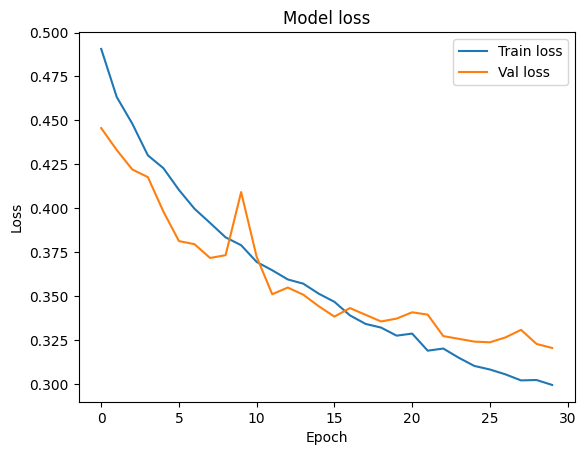

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_loss)), train_loss, label="Train loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="Val loss")
plt.legend()
plt.title("Model loss")
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.Sigmoid(),
            nn.Linear(500, 200),
            nn.Sigmoid(),
            nn.Linear(200, num_classes),
            nn.ReLU()
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Sigmoid-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
           Sigmoid-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
              ReLU-7                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
train_loss, val_loss, val_accuracy = train(model, train_loader, test_loader, loss_func, opt, epochs=30)

Epoch  0
	 Training loss:  2.1334585256413865
	 Validation loss:  2.112171047925949
	 Validation accuracy:  0.19482421875
Epoch  1
	 Training loss:  2.1072842530858544
	 Validation loss:  2.1082963347434998
	 Validation accuracy:  0.1955078125
Epoch  2
	 Training loss:  2.103688325200762
	 Validation loss:  2.1055239111185076
	 Validation accuracy:  0.1953125
Epoch  3
	 Training loss:  2.1021377252363194
	 Validation loss:  2.1077406257390976
	 Validation accuracy:  0.195703125
Epoch  4
	 Training loss:  2.1008621225479063
	 Validation loss:  2.1039636462926863
	 Validation accuracy:  0.19580078125
Epoch  5
	 Training loss:  2.098419756777505
	 Validation loss:  2.1027431756258013
	 Validation accuracy:  0.194921875
Epoch  6
	 Training loss:  2.0970058858013356
	 Validation loss:  2.10166372358799
	 Validation accuracy:  0.19521484375
Epoch  7
	 Training loss:  2.0959088332109106
	 Validation loss:  2.102936640381813
	 Validation accuracy:  0.19462890625
Epoch  8
	 Training loss:  2.09

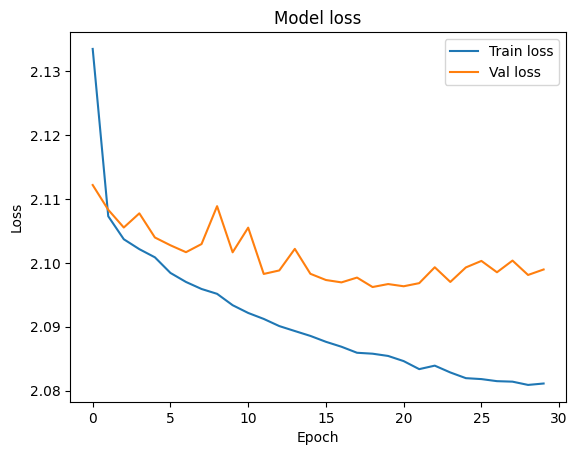

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_loss)), train_loss, label="Train loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="Val loss")
plt.legend()
plt.title("Model loss")
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.Sigmoid(),
            nn.BatchNorm1d(500),
            nn.Dropout(p=0.5),
            nn.Linear(500, 200),
            nn.Sigmoid(),
            nn.BatchNorm1d(200),
            nn.Dropout(p=0.5),
            nn.Linear(200, num_classes),
            nn.ReLU()
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Sigmoid-3                  [-1, 500]               0
       BatchNorm1d-4                  [-1, 500]           1,000
           Dropout-5                  [-1, 500]               0
            Linear-6                  [-1, 200]         100,200
           Sigmoid-7                  [-1, 200]               0
       BatchNorm1d-8                  [-1, 200]             400
           Dropout-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
             ReLU-11                   [-1, 10]               0
Total params: 496,110
Trainable params: 496,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
train_loss, val_loss, val_accuracy = train(model, train_loader, test_loader, loss_func, opt, epochs=20)

Epoch  0
	 Training loss:  0.5640907032784622
	 Validation loss:  0.4649277120828629
	 Validation accuracy:  0.8330078125
Epoch  1
	 Training loss:  0.4670729601878856
	 Validation loss:  0.43379193283617495
	 Validation accuracy:  0.84482421875
Epoch  2
	 Training loss:  0.4356685518455912
	 Validation loss:  0.43973280265927317
	 Validation accuracy:  0.84375
Epoch  3
	 Training loss:  0.41593576011373035
	 Validation loss:  0.40026580132544043
	 Validation accuracy:  0.85390625
Epoch  4
	 Training loss:  0.3988626889709725
	 Validation loss:  0.3909584142267704
	 Validation accuracy:  0.85703125
Epoch  5
	 Training loss:  0.3895809801339086
	 Validation loss:  0.4078129012137651
	 Validation accuracy:  0.85244140625
Epoch  6
	 Training loss:  0.3770929567023381
	 Validation loss:  0.3713619980961084
	 Validation accuracy:  0.86708984375
Epoch  7
	 Training loss:  0.37101858129887694
	 Validation loss:  0.35434248112142086
	 Validation accuracy:  0.873046875
Epoch  8
	 Training loss:

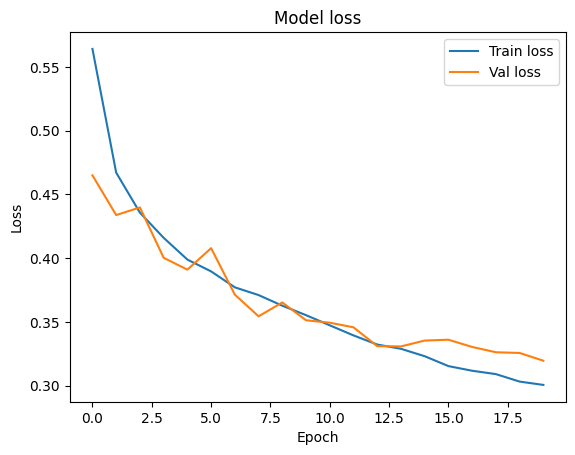

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_loss)), train_loss, label="Train loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="Val loss")
plt.legend()
plt.title("Model loss")
plt.show()

### Conclusions:
Dropout,Batchnorm help to prevent model overfitting. Also we should determine appropriate epochs count during internal experiments